### Using different Kernels in KOMP

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# generate SEM
import sys
sys.path.append("..")

from notears.notears.notears import linear
from notears.notears.notears import utils
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

True W:
[[0.   0.   0.  ]
 [0.9  0.   0.94]
 [0.9  0.   0.  ]].



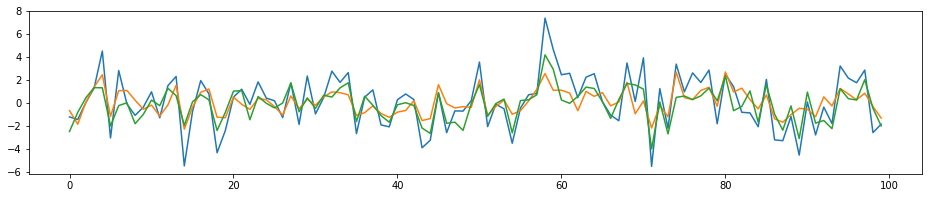

In [72]:
# set random seed
# utils.set_random_seed(1)

# print W
T, n, s0, graph_type, sem_type = 100, 3, 3, 'ER', 'gauss'
# W_true = utils.simulate_parameter(utils.simulate_dag(n, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
print(f"True W:\n{np.round(W_true, 2)}.\n")

# plot X
X = utils.simulate_linear_sem(W_true, T, sem_type)
plt.figure(figsize=(16, 3))
plt.plot(X);

# zero - mean
X_a = X - np.mean(X, axis = 0)

In [81]:
T = 1000
X = np.random.rand(T, n)
X -= np.mean(X, axis = 0)
W = np.array(range(n ** 2)).reshape(n, n) + 1
Y = np.exp(X) @ W + np.random.normal(0, 1, T * n).reshape(T, n)

In [74]:
def Lambda_to_adj(Lambda):
    """Convert Lambda list to adjacency matrix"""
    n = len(Lambda)
    
    adj_mat = np.zeros((n, n))
    
    for i, col in enumerate(Lambda):
        adj_mat[i, col] = 1 
    
    return adj_mat

In [83]:
def KOMP(X, Y, max_coefs = 1e10, tol = 0.0, verbose = False, output = False, normalize = True):
    """Do Kernel OMP on X, Y."""
    
    # get dimensions
    T, n = np.shape(X)
    
    F = [i * (n + 1) for i in range(n)]
    
    # compute kernel spaces
    Psi = (np.exp(X)).T.dot(np.exp(X))                    # p times p
    K = (np.exp(X)).T.dot(Y)                      # p  times p
    Theta = [y.T.dot(y) for y in Y.T]   # 1 times 1

    # initialize Lambda, idx, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))

    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array
    if normalize: norms = [np.linalg.norm(x) for x in X.T]
    
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        
        # set forbidden set to -1, impossible to pick then
#         gains = gains.flatten()
#         gains[F] = - np.ones(len(F))
#         gains = gains.reshape(n, n)

        # stopping criterion
        if np.round(gains, 5).max() <= tol: 
            print("Break")
            break
    
        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
        Lambda[col].append(row)
    
        # check if we have a DAG, not super efficient
        if True: # h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # update betas        	
            betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
    
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - Psi[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas 

print(np.round(KOMP(X, Y), 2))

[[1.04 1.87 2.93]
 [4.05 5.04 5.97]
 [6.89 8.06 9.07]]


$$\Phi(\cdot) = exp(\cdot)\text{, such that we have }Y = \exp(X)\ W$$